# PANOSETI PSF Approximation
Approximate a point fwhm function for PANOSETI optics according to figure 3 in https://ui.adsabs.harvard.edu/abs/2018SPIE10702E..5LM/abstract

Author: Nik Korzoun 

In [278]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import scipy as sp

In [279]:
# points from figure 3
fwhm = [0.38,0.51,0.72]#*u.mm
sep = [0, 2.5, 5]#*u.degree

### Linear

In [280]:
# linear fit
fit1 = np.polyfit(sep, fwhm, 1)
lin = np.poly1d(fit1)
fit1

array([0.068     , 0.36666667])

In [281]:
# quadratic fit
fit2 = np.polyfit(sep, fwhm, 2)
quad = np.poly1d(fit2)
fit2

array([0.0064, 0.036 , 0.38  ])

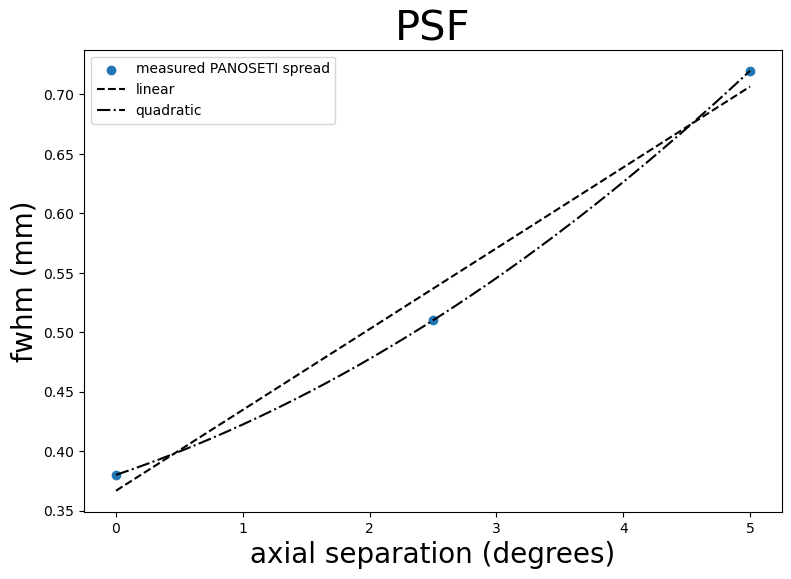

In [282]:
fig = plt.figure(figsize=(9,6))
plt.scatter(sep,fwhm,label='measured PANOSETI spread')
plt.title("PSF",fontsize=30) 
plt.xlabel('axial separation (degrees)',fontsize=20)
plt.ylabel('fwhm (mm)',fontsize=20)

seps = np.linspace(0,5,500)
plt.plot(seps,lin(seps),c='k',label='linear',ls='--')
plt.plot(seps,quad(seps),c='k',label='quadratic',ls='-.')
plt.legend()

In [283]:
quad(2.6)

0.5168639999999998

# More sophisticated modeling
From https://web.physik.rwth-aachen.de/user/hebbeker/theses/eichler_master.pdf

In [284]:
# lens aperture
a = 460.9 * u.mm

# groove spacing
spacing = 0.508 * u.mm
line_number = 1/spacing
N_grooves = line_number * a

# Eq 29
def intensity(r,i_0=1,wvlen=350*u.nm,flen=607.8*u.mm):
    sum = 0
    for j in range(1,int(N_grooves)+1):
        eta = (j*spacing) / ((j+1)*spacing)
        x = 2*np.pi*(j+1)*spacing*r/ (wvlen*flen)

        term1 = ( ((j+1)*spacing)**2 - (j*spacing)**2 ) / (spacing**2)
        term2 = i_0/(1-eta**2)**2
        term3 = ( (2*sp.special.jv(1,x)/x) - (2*eta*sp.special.jv(1,eta*x)/x) )**2

        sum += term1*term2*term3

    return sum


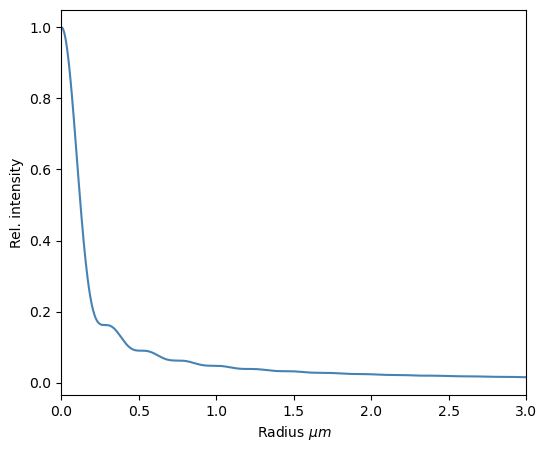

In [285]:
fig,ax = plt.subplots(figsize=(6,5))
plt.xlabel(r'Radius $\mu m$')
plt.ylabel('Rel. intensity')
ax.set_xlim(0,3)

# model
radii = np.linspace(1e-4,3,1000)*u.um
intensities=intensity(radii)
ax.plot(radii,intensities/intensity(1e-9*u.um),c='steelblue',label=r'Fresnel intensity $I/I_0$')

## Load in Data

In [286]:
tiff=plt.imread('/home/nkorzoun/Downloads/wl-0deg.tif')
# tiff=plt.imread('/home/nkorzoun/Downloads/NIR15l.tif')
# tiff=plt.imread('/home/nkorzoun/Downloads/NIR15lb.tif')

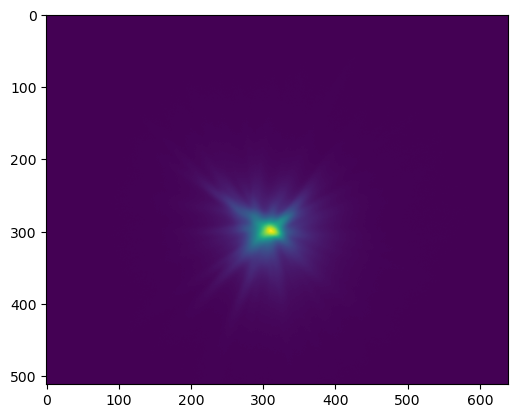

In [287]:
plt.imshow(tiff)

In [288]:
tiff.shape

(512, 640)

In [289]:
# find maximum
max = np.unravel_index(np.argmax(tiff),tiff.shape)
index = max[0]

In [290]:
index

300

In [291]:
center=np.argmax(tiff[index])

In [292]:
center

312

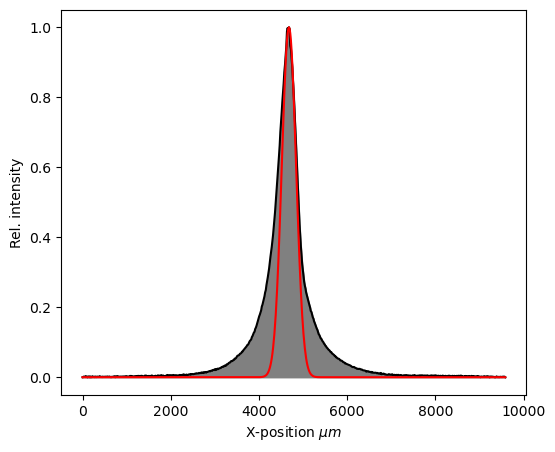

In [293]:
fig,ax = plt.subplots(figsize=(6,5))
plt.xlabel(r'X-position $\mu m$')
plt.ylabel('Rel. intensity')

#data
values=tiff[index]
x=np.arange(0,tiff.shape[1])*15*u.um
ax.plot(x,values/np.max(values),color='k')
ax.fill_between(x/u.um,values/np.max(values),color='gray')

ax.plot(x,380/2.355*np.sqrt(2*np.pi)*sp.stats.norm.pdf(x,center*15,380/2.355),color='red')

## Combined Plot

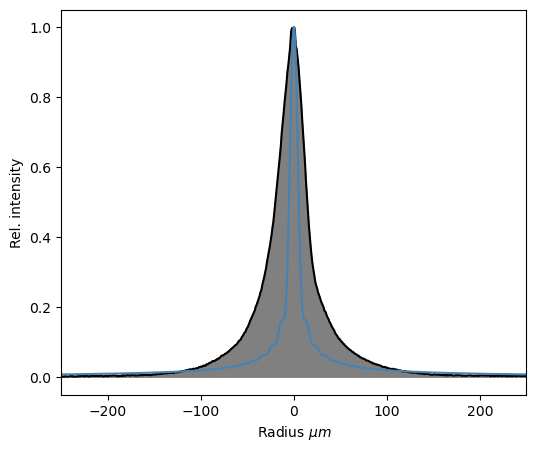

In [294]:
fig,ax = plt.subplots(figsize=(6,5))
plt.xlabel(r'Radius $\mu m$')
plt.ylabel('Rel. intensity')
ax.set_xlim(-250,250)

# scale_factor=1/30

#data
values=tiff[index]
x=np.arange(0,tiff.shape[1])
x=x-center
# x=(x-center)*scale_factor
ax.plot(x,values/np.max(values),color='k')
ax.fill_between(x,values/np.max(values),color='gray')

# model
radii = np.linspace(-1000,1000,2000)*u.um
radii = radii
intensities=intensity(radii/10,i_0=np.max(values),wvlen=1500*u.nm)
ax.plot(radii,intensities/np.max(intensities),c='steelblue')

# 2-Gaussian

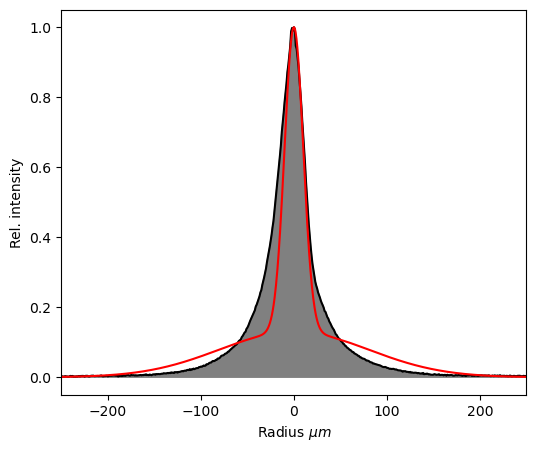

In [295]:
fig,ax = plt.subplots(figsize=(6,5))
plt.xlabel(r'Radius $\mu m$')
plt.ylabel('Rel. intensity')
ax.set_xlim(-250,250)

# model
radii = np.linspace(-500,500,2000)*u.um
# radii = radii
# intensities=intensity(radii,i_0=np.max(values),wvlen=350*u.nm)
# ax.plot(radii,intensities/np.max(intensities),c='steelblue')

#data
values=tiff[index]
x=np.arange(0,tiff.shape[1])
x=x-center
# x=(x-center)*scale_factor
ax.plot(x,values/np.max(values),color='k')
ax.fill_between(x,values/np.max(values),color='gray')

def twoGauss(x,a,b,u1,s1,u2,s2):
    g1 = np.exp(-0.5*((x-u1)**2)/(s1**2))
    g2 = np.exp(-0.5*((x-u2)**2)/(s2**2))
    
    return (a*g1+b*g2)/(a+b)

ax.plot(radii,twoGauss(radii/u.um,2,0.3,0,10,0,80),color='red')

## R90 and FWHM

In [296]:
def r90(image):

    y, x = np.indices(image.shape)
    cy, cx= sp.ndimage.center_of_mass(image)

    r = np.hypot(x-cx,y-cy)

    image_flat=image.ravel()
    r_flat = r.ravel()

    sorted_indices = np.argsort(r_flat)
    sorted_r = r_flat[sorted_indices]
    sorted_flux = image_flat[sorted_indices]

    cumulative_flux = np.cumsum(sorted_flux)
    total_flux=cumulative_flux[-1]

    r90_index = np.searchsorted(cumulative_flux, 0.9*total_flux)
    r90 = sorted_r[r90_index]

    return r90

In [297]:
def fwhm(image):

    peak_y, peak_x = np.unravel_index(np.argmax(image),image.shape)
    peak_value = image[peak_y, peak_x]

    half_max = 0.5*peak_value
    mask = image >= half_max

    y_indices, x_indices = np.where(mask)

    distance = np.hypot(x_indices-peak_x,y_indices-peak_y)

    fwhm=2*np.median(distance)

    return fwhm

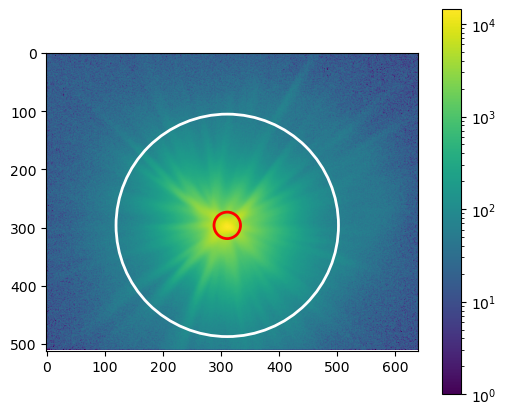

In [322]:
fig,ax = plt.subplots(figsize=(6,5))

im=ax.imshow(tiff,norm='log')
bar=plt.colorbar(im)

cy, cx= sp.ndimage.center_of_mass(tiff)

circ90 = plt.Circle([cx,cy], r90(tiff), facecolor='None', edgecolor='white', lw=2)
ax.add_patch(circ90)

circFWHM = plt.Circle([cx,cy], fwhm(tiff), facecolor='None', edgecolor='red', lw=2)
ax.add_patch(circFWHM)

In [299]:
r90(tiff)*15*u.um

<Quantity 2870.28811198 um>

In [300]:
fwhm(tiff)*15*u.um

<Quantity 342.05262753 um>